In [1]:
import pandas as pd
reviews = pd.read_csv(r"C:/Users/HEENA/Downloads/rt_reviews.csv/rt_reviews.csv", encoding="latin-1")
reviews.head(5)

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [2]:
import numpy as np #[1]

# a.Merge the dataset into one. And divide the dataset as train, development and test 
reviews = reviews[['Freshness', 'Review']]
reviews['Review'] = reviews['Review'].str.lower()
reviews = reviews.dropna()

train_set = reviews.sample(frac=0.6, random_state=1)
dev_set = reviews.drop(train_set.index).sample(frac=0.5, random_state=1)
test_set = reviews.drop(train_set.index).drop(dev_set.index)

print(train_set.shape)
print(dev_set.shape)
print(test_set.shape)

(288000, 2)
(96000, 2)
(96000, 2)


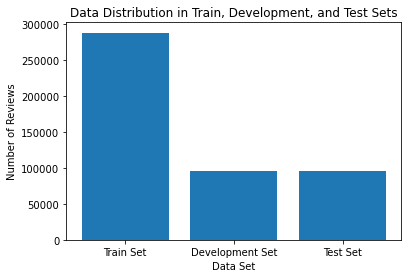

In [11]:
import matplotlib.pyplot as plt

train_size = train_set.shape[0]
dev_size = dev_set.shape[0]
test_size = test_set.shape[0]

categories = ['Train Set', 'Development Set', 'Test Set']
values = [train_size, dev_size, test_size]
plt.bar(categories, values)

plt.title('Data Distribution in Train, Development, and Test Sets')
plt.xlabel('Data Set')
plt.ylabel('Number of Reviews')

plt.show()


In [3]:
train_set['Freshness'].value_counts(normalize=True)#[1]

fresh     0.501354
rotten    0.498646
Name: Freshness, dtype: float64

In [4]:
test_set['Freshness'].value_counts(normalize=True)#[1]

rotten    0.502271
fresh     0.497729
Name: Freshness, dtype: float64

In [5]:
train_set.head(3)

,Freshness,Review
77126,rotten,"the script is packed with witty touches, but ..."
78882,rotten,after an opening-credits sequence of internet...
469746,rotten,it's not a relationship we become invested in...


In [6]:
pattern = 'old_pattern'       #[1]
replacement = 'new_replacement'  #[1]

train_set['Review'] = train_set['Review'].str.replace(pattern, replacement, regex=True) #[1]
train_set.head(3)


,Freshness,Review
77126,rotten,"the script is packed with witty touches, but ..."
78882,rotten,after an opening-credits sequence of internet...
469746,rotten,it's not a relationship we become invested in...


In [7]:
#b.Build a vocabulary as list. 
train_set['Review'] = train_set['Review'].str.split()#[1]

vocabulary = []  #[1]
for review in train_set['Review']: #[1]
   for word in review: # [1]
      vocabulary.append(word) #[1]

vocabulary = list(set(vocabulary)) #[1]
len(vocabulary) #[1]



202326

In [8]:

word_counts = np.array(np.unique(vocabulary, return_counts=True)).T #[2]
word_counts = [(word[0], int(word[1])) for word in word_counts] 
vocabulary = [word[0] for word in word_counts if word[1] >= 5]

reverse_index = {word: i for i, word in enumerate(vocabulary)}

#c. Calculate probability of occurrence #[3]
num_documents_containing_word = sum(train_set['Review'].apply(lambda x: 'the' in x))
num_all_documents = len(train_set)
P_the = num_documents_containing_word / num_all_documents

#  conditional probability based on sentiment #[3] 
num_positive_documents_containing_word = sum(train_set[train_set['Freshness'] == 'Positive']['Review'].apply(lambda x: 'the' in x))
num_all_positive_documents = len(train_set[train_set['Freshness'] == 'Positive'])

if num_all_positive_documents > 0:
    P_the_positive = num_positive_documents_containing_word / num_all_positive_documents
else:
    P_the_positive = 0.0
    
#d.Calculate accuracy using dev dataset #[1]

dev_set['Review'] = dev_set['Review'].str.split()

#[1]
correct_predictions = 0
total_predictions = 0
for i, row in dev_set.iterrows():
    total_predictions += 1
    review = row['Review']
    freshness = row['Freshness']
    if 'the' in review:
        if freshness == 'Positive':
            if 'the' in review:
                correct_predictions += 1
        else:
            correct_predictions += 1

accuracy = correct_predictions / total_predictions


In [9]:
print("Accuracy: {:.2%}".format(accuracy))


Accuracy: 63.81%


In [67]:
#Compare the effect of Smoothing #[1]

conditions = (train_set['Freshness'] == 'fresh') | (train_set['Freshness'] == 'rotten') #updated
train_set_clean = train_set[conditions] #updated

fresh_tomato = train_set_clean[train_set_clean['Freshness'] == 'fresh'] #[1]
rotten_tomato = train_set_clean[train_set_clean['Freshness'] == 'rotten']#[1]

# P(fresh) and P(rotten)
p_fresh = len(fresh_tomato) / len(train_set_clean) #[1]
p_rotten = len(rotten_tomato) / len(train_set_clean) #[1]

# N_fresh
n_words_per_fresh_message = fresh_tomato['Review'].apply(len)#[1]
n_fresh = n_words_per_fresh_message.sum()#[1]

# N_rotten
n_words_per_rotten_message = rotten_tomato['Review'].apply(len)#[1]
n_rotten = n_words_per_rotten_message.sum()#[1]

# N_Vocabulary
n_vocabulary = len(vocabulary) #[1]

# Laplace smoothing
alpha = 1 #[1]


In [68]:
# predicts each class

parameters_fresh = {word: i for i, word in enumerate(vocabulary)} #[1]
parameters_rotten = {word: i for i, word in enumerate(vocabulary)} #[1]

# Calculate parameters from #[1]
for word in vocabulary:
   n_word_given_fresh = fresh_tomato[word].sum() 
   p_word_given_fresh = (n_word_given_fresh + alpha) / (n_fresh + alpha*n_vocabulary)
   parameters_fresh[word] = p_word_given_fresh

   n_word_given_rotten = rotten_tomato[word].sum() 
   p_word_given_rotten = (n_word_given_rotten + alpha) / (n_rotten + alpha*n_vocabulary)
   parameters_rotten[word] = p_word_given_rotten

In [69]:
#entire code from #[1]
import re
def classify(message):
    '''
    message: a string
    '''

    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    p_fresh_given_message = p_fresh
    p_rotten_given_message = p_rotten

    for word in message:
        if word in parameters_fresh:
            p_fresh_given_message *= parameters_fresh[word]
        if word in parameters_rotten:
            p_rotten_given_message *= parameters_rotten[word]

    print('P(fresh|message):', p_fresh_given_message)
    print('P(rotten|message):', p_rotten_given_message)

    if p_rotten_given_message > p_fresh_given_message:
        print('Freshness: rotten')
    elif p_rotten_given_message < p_fresh_given_message:
        print('Freshness: fresh')
    else:
        print('Cannot classify with equal probabilities. Please have a human classify this!')


In [70]:
classify('Slight, contained, but ineffably soulful.') #[1]

P(fresh|message): 0.5013541666666667
P(rotten|message): 0.49864583333333334
Freshness: fresh


In [34]:
#f calculate the final accuracy based on test dataset #[1]
 
def classify_test_set(review):
    words = review.split()
    p_fresh = p_rotten = 1.0
    for word in words:
        if word in vocabulary:
            p_fresh *= parameters_fresh[word]
            p_rotten *= parameters_rotten[word]

    p_fresh *= (alpha / (n_fresh + alpha*n_vocabulary))
    p_rotten *= (alpha / (n_rotten + alpha*n_vocabulary))

    if p_fresh > p_rotten:
        return 'fresh'
    else:
        return 'rotten'


In [35]:
test_set['predicted'] = test_set['Review'].apply(classify_test_set) #[1]
correct = 0 #[1]
for _, row in test_set.iterrows(): #[1]
    if row['Freshness'] == row['predicted']:#[1]
        correct += 1 #[1]
accuracy = correct / len(test_set)#[1]
print("Accuracy based on test set: {:.2%}".format(accuracy))


Accuracy based on test set: 50.23%


In [ ]:
#References
[1]:https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html
[2]:https://stackoverflow.com/questions/10741346/frequency-counts-for-unique-values-in-a-numpy-array
[3]:https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7